# <center>Heart Disease UC Irvine - Detection </center>



**Author:** E Kaldany 

**Description:** 

This notebook demonstrates heart disease classification using a random forrest. 

**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Analyze data](#2-bullet)
3. [Manipulate data](#3-bullet)
4. [Model and validate data](#4-bullet)
5. [Predictions](#5-bullet)



# 1. Libraries and settings <a class="anchor" id="1-bullet"></a> 

In [1]:
import pandas as pd

import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns


# 2. Analyze data <a class="anchor" id="2-bullet"></a> 
- load UCI heart disease data
- analyze and visualize data

In [2]:
# read the data
df = pd.read_csv("/kaggle/input/heart-disease-uci/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
df.shape

(303, 14)

In [4]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Note: all features of this dataset are numerical

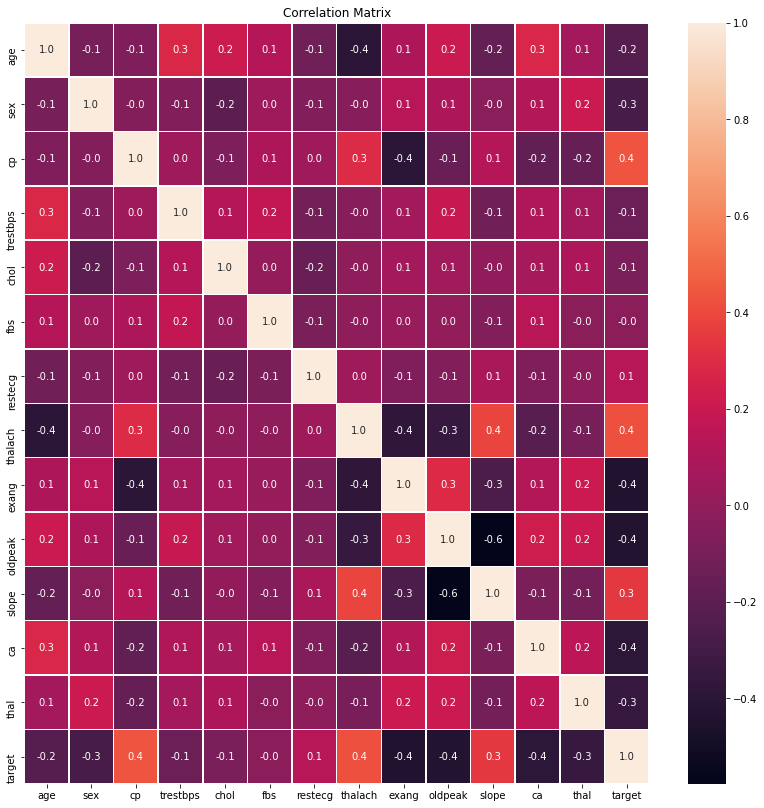

In [5]:
f,ax = plt.subplots(figsize=(14, 14))
ax = ax.set_title("Correlation Matrix")
fig = sns.heatmap(df.corr(), annot=True, linewidths=.5,  fmt= '.1f', label = 'small')
fig = fig.get_figure()

In [6]:
df.nunique()

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64

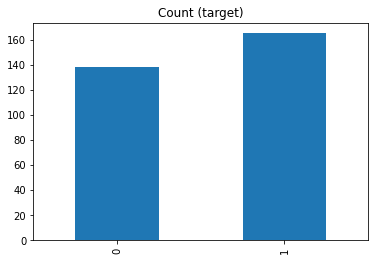

In [7]:
target_count = df.target.value_counts()
target_count.plot(kind='bar', title='Count (target)');

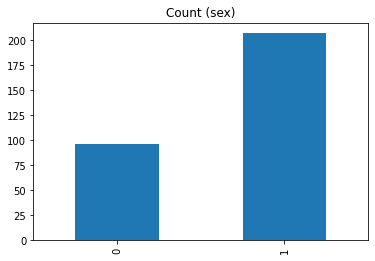

In [8]:
target_count = df.sex.value_counts()
target_count.plot(kind='bar', title='Count (sex)');

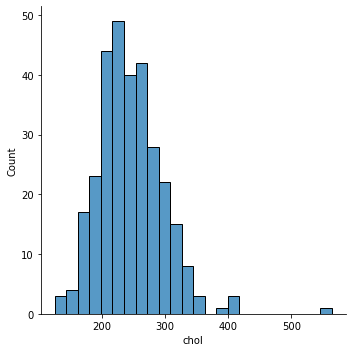

In [9]:
sns.displot(df['chol'], kde = False)

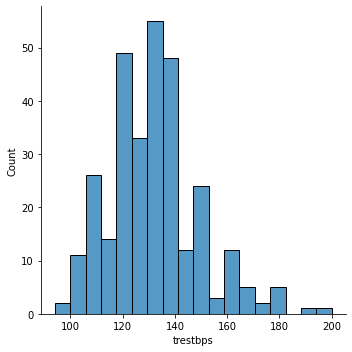

In [10]:
sns.displot(df['trestbps'], kde = False)

# 3. Manipulate data <a class="anchor" id="3-bullet"></a> 
- split training and validation data

In [11]:
# split inputs and output
X = df.drop(columns='target')
y = df['target']

In [12]:
# Split training and testing data sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [13]:
# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Series([], dtype: int64)


In [14]:
# Select categorical columns with relatively low cardinality <10 (convenient but arbitrary)
categorical_cols = [cname for cname in X_train.columns if
                    X_train[cname].nunique() < 10 and 
                    X_train[cname].dtype == "object"]

In [15]:
# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if 
                X_train[cname].dtype in ['int64', 'float64']]

In [16]:
# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train[my_cols].copy()
X_valid = X_valid[my_cols].copy()

# 4. Model and validate data <a class="anchor" id="4-bullet"></a> 

## Model 1: Random Forest

In [17]:
# Pipeline information

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [18]:
# Define model
model = RandomForestClassifier(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

In [19]:
# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['age', 'sex', 'cp',
                                                   'trestbps', 'chol', 'fbs',
                                                   'restecg', 'thalach',
                                                   'exang', 'oldpeak', 'slope',
                                                   'ca', 'thal']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                          

## Model 2: Cross-validated, Tuned Random Forest

In [20]:
def get_score(n_estimators):
    """Return the average accuracy over 3 CV folds of random forest model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    my_pipeline = Pipeline(steps = [('preprocessor', SimpleImputer()),
                                    ('model', RandomForestClassifier(n_estimators, random_state = 42))])
    scores = cross_val_score(my_pipeline, X, y,
                                  cv = 3,
                                  scoring = 'accuracy')
    return scores.mean()

In [21]:
# Iterations of parameters
results = {}

for i in range(1,20):
    results[50 * i] = get_score(50 * i)

n_estimators_best = max(results, key = results.get)

In [22]:
print(results)
print(results[n_estimators_best])

{50: 0.8283828382838284, 100: 0.8382838283828383, 150: 0.8316831683168316, 200: 0.834983498349835, 250: 0.8316831683168316, 300: 0.8316831683168316, 350: 0.834983498349835, 400: 0.834983498349835, 450: 0.8316831683168316, 500: 0.834983498349835, 550: 0.8283828382838284, 600: 0.834983498349835, 650: 0.8382838283828383, 700: 0.8382838283828383, 750: 0.8316831683168316, 800: 0.834983498349835, 850: 0.8316831683168316, 900: 0.8316831683168316, 950: 0.8283828382838284}
0.8382838283828383


## Model 3: XGB Classifier

In [23]:
# Preprocessing of validation data, get predictions
my_model3 = XGBClassifier(n_estimators=50, learning_rate=0.15)
my_model3.fit(X_train, y_train, 
             early_stopping_rounds=8, 
             eval_metric= 'error',
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# 5. Prediction <a class="anchor" id="5-bullet"></a> 

In [24]:
preds1 = clf.predict(X_valid)

In [25]:
preds3 = my_model3.predict(X_valid)

In [26]:
print('Model 1 Accuracy Score:', accuracy_score(y_valid, preds1))
print('Model 2 Accuracy Score:', results[n_estimators_best])
print('Model 3 Accuracy Score:', accuracy_score(y_valid, preds3))

Model 1 Accuracy Score: 0.8852459016393442
Model 2 Accuracy Score: 0.8382838283828383
Model 3 Accuracy Score: 0.8688524590163934
